In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import healpy as hp

import yaml

from Qatmosphere_2d import Atmsophere

import scipy
import scipy.special as sci_spe
import time
from astropy.time import TimeDelta
 
import sys
import yaml

sys.path.append('/home/laclavere/qubic/qubic/Pipeline')

import qubic
from qubic.lib.Qscene import QubicScene

from pyoperators.iterative.core import AbnormalStopIteration
from pysimulators import (
    CartesianEquatorial2GalacticOperator,
    CartesianEquatorial2HorizontalOperator,
    CartesianHorizontal2EquatorialOperator,
    CartesianGalactic2EquatorialOperator,
    SamplingHorizontal,
    SphericalEquatorial2GalacticOperator,
    SphericalGalactic2EquatorialOperator,
    SphericalEquatorial2HorizontalOperator,
    SphericalHorizontal2EquatorialOperator)
from pysimulators.interfaces.healpy import Cartesian2HealpixOperator, Spherical2HealpixOperator
from pyoperators import *

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
with open('/home/laclavere/Documents/Thesis/qubic/qubic/scripts/Atmosphere/params.yml', 'r') as file:
    params = yaml.safe_load(file)

In [3]:
atm = Atmsophere(params)

In [4]:
rho = atm.mean_water_vapor_density
print(rho)

[0.99597489]


In [5]:
delta_rho = atm.generate_spatial_fluctuations_2d()
print(type(delta_rho))

<class 'numpy.ndarray'>


In [6]:
atm.get_water_vapor_density_2d_map()

array([[56.49325886, 56.54821077, 56.54320772, ..., 56.42206196,
        56.41474359, 56.5031597 ],
       [56.52010945, 56.53813097, 56.54215569, ..., 56.48475236,
        56.44703525, 56.49668637],
       [56.55378532, 56.56367751, 56.5205802 , ..., 56.4398939 ,
        56.47409849, 56.51721974],
       ...,
       [56.51500092, 56.52614893, 56.55692143, ..., 56.54204454,
        56.5528534 , 56.57465065],
       [56.54215861, 56.55980059, 56.5810907 , ..., 56.41963004,
        56.46205579, 56.51018774],
       [56.51607081, 56.55108542, 56.55173514, ..., 56.44918963,
        56.42760393, 56.4853925 ]])

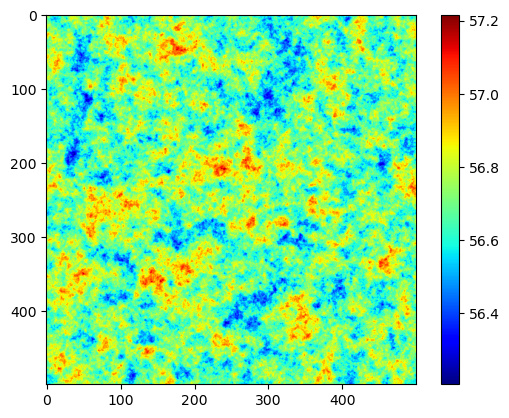

In [7]:
plt.imshow(atm.get_water_vapor_density_2d_map(), cmap='jet')
plt.colorbar()

In [8]:
map_temp = atm.get_maps()
frequencies = atm.integrated_absorption_spectrum()[1]

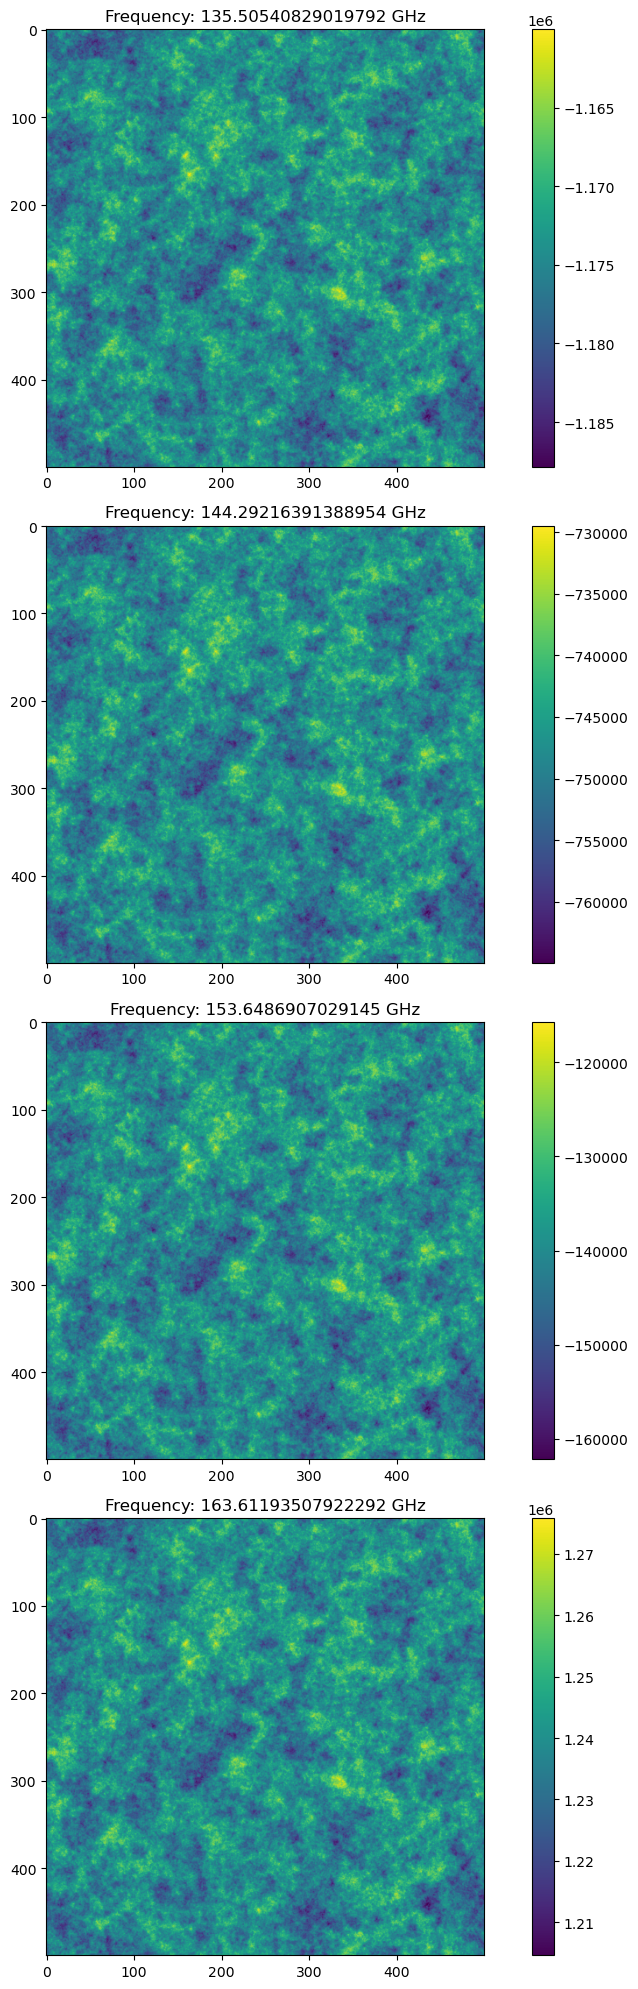

In [9]:
fig, axs = plt.subplots(len(frequencies), 1, figsize=(10, 5*len(frequencies)))
for i in range(len(frequencies)):
    im = axs[i].imshow(map_temp[i])
    plt.colorbar(im, ax=axs[i])
    axs[i].set_title(f'Frequency: {frequencies[i]} GHz')
plt.tight_layout()
plt.show()

In [10]:
healpy_atm_maps = atm.get_healpy_atm_maps_2d()

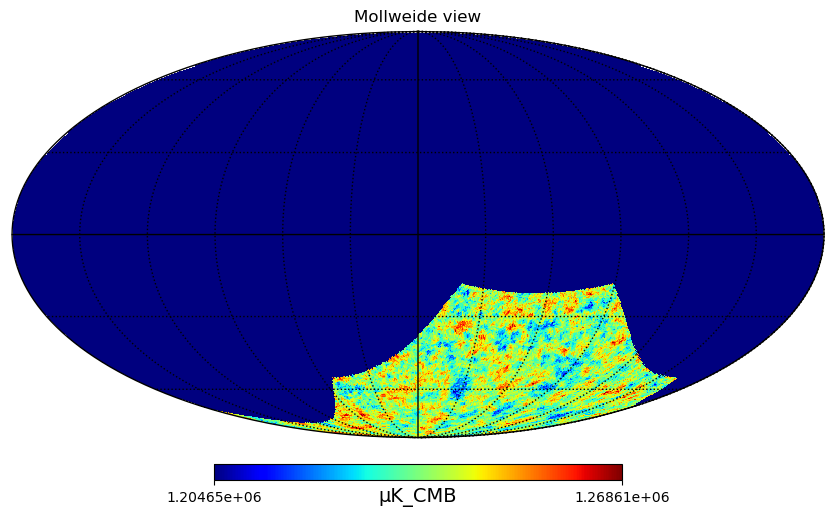

In [11]:
hp.mollview(healpy_atm_maps[-1] ,min=np.min(map_temp[-1]), cmap='jet', unit='µK_CMB')
hp.graticule()

In [12]:
from qubic.scripts.MapMaking.src.FMM.model.planck_timeline import InputMaps
from pyoperators import *
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [13]:
cmb_maps = InputMaps({'cmb':42}, atm.frequencies, 2, params['nside']).m_nu

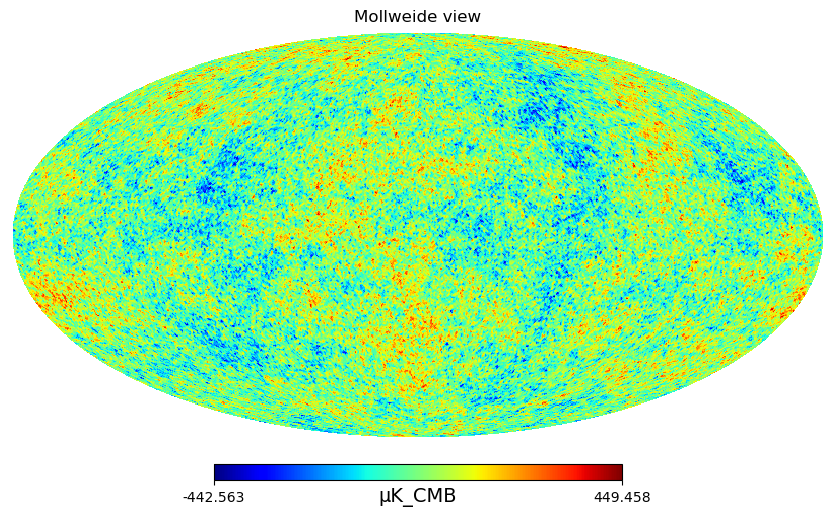

In [14]:
hp.mollview(cmb_maps[-1, :, 0],cmap='jet', unit='µK_CMB')

In [15]:
input_maps = cmb_maps.copy()
input_maps[:, :, 0] += healpy_atm_maps

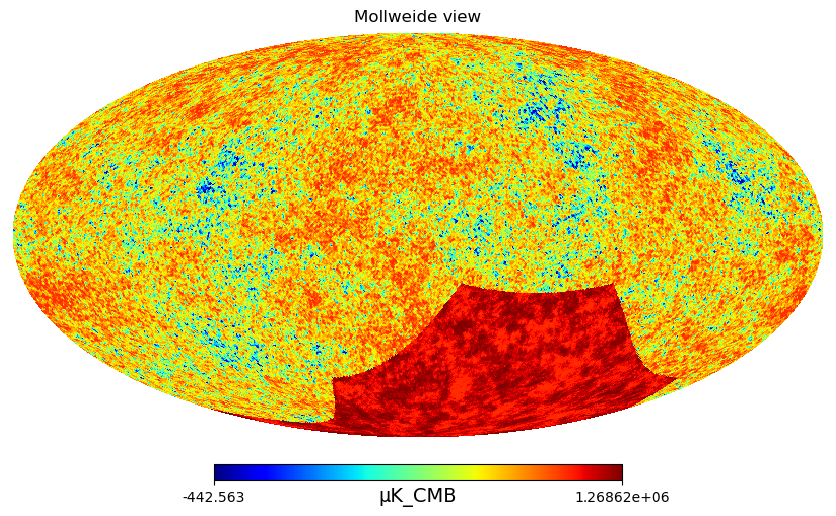

In [16]:
hp.mollview(input_maps[-1, :, 0] ,cmap='jet', unit='µK_CMB', norm='hist')

In [17]:
qubic_sampling = qubic.lib.Qsamplings.QubicSampling(params['npointing'], date_obs=atm.qubic_dict['date_obs'], period=1, latitude=atm.qubic_dict['latitude'], longitude=atm.qubic_dict['longitude'])

In [18]:
r = np.random.RandomState(2)

cosdtheta = np.cos(np.radians(20))
theta = np.degrees(np.arccos(cosdtheta + (1 - cosdtheta) * r.rand(params['npointing'])))
phi = r.rand(params['npointing']) * 360
pitch = r.rand(params['npointing']) * 360

In [19]:
center = np.array([0, -57])

In [20]:
c2s = Cartesian2SphericalOperator('azimuth,elevation')
rot = Rotation3dOperator("ZY'", - atm.qubic_dict['latitude'], atm.qubic_dict['longitude'])
s2c = Spherical2CartesianOperator('zenith, azimuth', degrees=True)
rotation = c2s((rot(s2c)))
coords = rotation(np.asarray([theta, phi]).T)
azimuth_qubic = coords[..., 0]
elevation_qubic = coords[..., 1]

In [21]:
hp_test = np.zeros(hp.nside2npix(params['nside']))
az, el = [], []
rotation_azel2hp = Spherical2HealpixOperator(params['nside'], 'azimuth,elevation')
for az_ in azimuth_qubic:
    for el_ in elevation_qubic:
        az.append(az_)
        el.append(el_)
hp_test_index = rotation_azel2hp(np.asarray([azimuth_qubic, elevation_qubic]).T).astype(int)
hp_test[hp_test_index] = 1

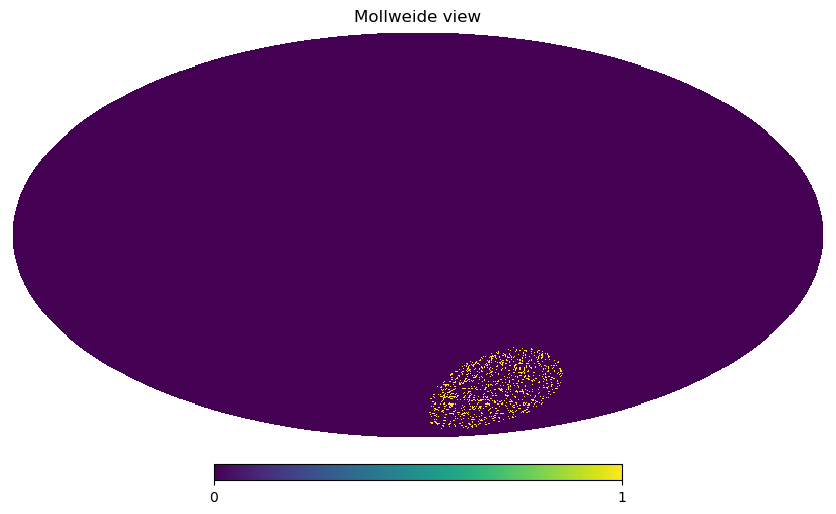

In [22]:
hp.mollview(hp_test)

# Map-making

In [23]:
Qacq = qubic.lib.InstrumentModel.Qacquisition.QubicDualBand(atm.qubic_dict, nsub=params['nsub_in'], nrec=params['nrec'])
H = Qacq.get_operator(fwhm=Qacq.allfwhm)
invN = Qacq.get_invntt_operator()
        

You asked 3000 pointings with repeat strategy so I will provide 1000 pointings repeated 3 times.
Info apcnb2325: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.
Info apcnb2325: Allocating (2976000,9) elements = 408.69140625 MiB in FSRRotation3dMatrix.__init__.


In [24]:
#coverage = joint.qubic.subacqs[0].get_coverage()
coverage = Qacq.coverage
npix_qubic=0
for i in coverage:
    if i!=0:
        npix_qubic+=1
covnorm = coverage / coverage.max()
seenpix = covnorm > 0.1
fsky = seenpix.astype(float).sum() / seenpix.size
coverage_cut = coverage.copy()
coverage_cut[~seenpix] = 1

mask = np.ones(12*params['nside']**2)
mask[seenpix] = 0

In [25]:
A = H.T * invN * H
b = H.T * invN * H(input_maps)
x0 = input_maps + 1e-3 * np.random.randn(input_maps.shape[0], input_maps.shape[1], input_maps.shape[2])  

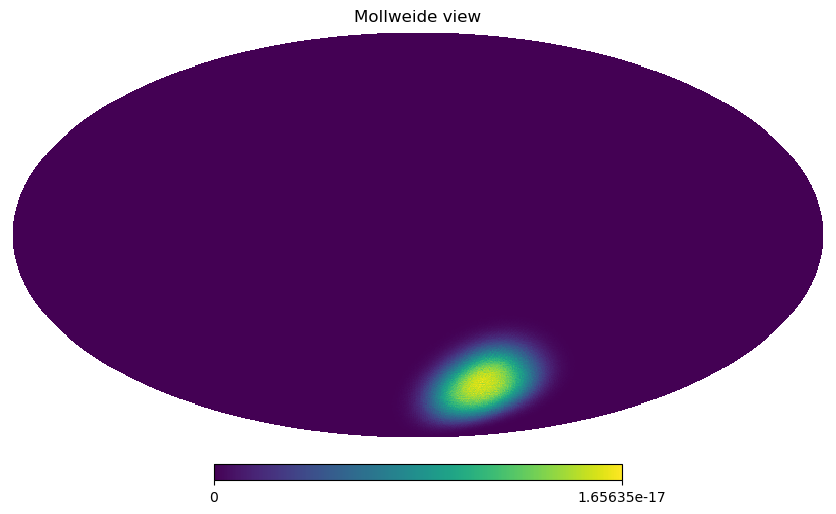

In [26]:
x0[:, ~seenpix, :] = 0
hp.mollview(coverage)

In [28]:
import time
from qubic.lib.Qcg import PCGAlgorithm
time0 = time.time()
algo = PCGAlgorithm(
    A,
    b,
    comm,
    x0=x0,
    tol=1e-18,
    maxiter=50,
    disp=True,
    M=None,
    center=center,
    reso=15,
    seenpix=seenpix,
)
try:
    output = algo.run()
    success = True
    message = 'Success'
except AbnormalStopIteration as e:
    output = algo.finalize()
    success = False
    message = str(e)

TypeError: 'NoneType' object is not subscriptable

In [25]:
stop

NameError: name 'stop' is not defined

In [13]:
from lib.InstrumentModel.Qacquisition import QubicMultiAcquisitions

ModuleNotFoundError: No module named 'lib'

In [10]:
def get_dict(params, comm, key='in'):
    """QUBIC dictionary.

    Method to modify the qubic dictionary.

    Parameters
    ----------
    key : str, optional
        Can be "in" or "out".
        It is used to build respectively the instances to generate the TODs or to reconstruct the sky maps,
        by default "in".

    Returns
    -------
    dict_qubic: dict
        Modified QUBIC dictionary.

    """

    args = {
        "npointings": params["QUBIC"]["npointings"],
        "nf_recon": params["QUBIC"]["nrec"],
        "nf_sub": params["QUBIC"][f"nsub_{key}"],
        "nside": params["SKY"]["nside"],
        "MultiBand": True,
        "period": 1,
        "RA_center": params["SKY"]["RA_center"],
        "DEC_center": params["SKY"]["DEC_center"],
        "filter_nu": 150 * 1e9,
        "noiseless": False,
        "comm": comm,
        "dtheta": params["QUBIC"]["dtheta"],
        "nprocs_sampling": 1,
        "nprocs_instrument": comm.Get_size(),
        "photon_noise": True,
        "nhwp_angles": 3,
        #'effective_duration':3,
        "effective_duration150": 3,
        "effective_duration220": 3,
        "filter_relative_bandwidth": 0.25,
        "type_instrument": "two",
        "TemperatureAtmosphere150": None,
        "TemperatureAtmosphere220": None,
        "EmissivityAtmosphere150": None,
        "EmissivityAtmosphere220": None,
        "detector_nep": float(params["QUBIC"]["NOISE"]["detector_nep"]),
        "synthbeam_kmax": params["QUBIC"]["SYNTHBEAM"]["synthbeam_kmax"],
    }

    ### Get the default dictionary
    dictfilename = "dicts/pipeline_demo.dict"
    dict_qubic = qubic.lib.Qdictionary.qubicDict()
    dict_qubic.read_from_file(dictfilename)

    for i in args.keys():

        dict_qubic[str(i)] = args[i]

    return dict_qubic